# Selenium vs AI Self-Healing Locators

## Introduction

In this lab, you’ll see why UI tests become brittle when DOM attributes change—and how an AI-assisted, **self-healing locator** can recover from those changes safely. We’ll build a tiny demo site with two versions:

* **v1** (original) where a Selenium test passes.
* **v2** (mutated) where the same test **fails** because the locator breaks.

Then we’ll compare three strategies:

1. **Plain Selenium** (brittle baseline)
2. **AI Embedding-based selector** via open-source models (DOM-semantic similarity)
3. *(Optional)* **LLM reranker** via open-source models (structured JSON rationale)

You’ll finish with a side-by-side results table, confidence scores, and a short analysis of pass/fail behavior.

**Audience:** SDETs, QA Engineers, Test Leads, and Developers who maintain UI automation.
**Prereqs:** Basic Python; familiarity with Selenium; access to open-source models (for AI steps).
**Outcomes:**

* Understand why classic locators (id/css/xpath) fail after small UI changes.
* Implement a safe “fail-closed” self-healing locator using embeddings (and optionally an LLM).
* Collect evidence (pass rates, confidence, top-K candidates) to justify adopting AI selectors.



## Why tests break

Selenium targets elements using **exact match** rules (e.g., `id`, CSS, XPath). Minor UI refactors—renaming `id`, moving the element, or changing nearby text—often invalidate those rules, causing **NoSuchElementException** or clicking the **wrong** element. Common causes:

* Renamed attributes/classes or swapped `data-testid`s
* Element reparenting / layout changes
* Content tweaks (“Sign in” → “Log in”)
* Duplicate/ambiguous elements

## Traditional mitigation (and its limits)

* Prefer **stable attributes** (`data-testid`, ARIA roles).
* Layer **multiple selectors** as fallbacks.
* Keep **page objects** centralized.
  These help, but still rely on brittle exact matches.

## Self-healing via AI (DOM semantics)

Instead of relying solely on exact attributes, we encode **intent** (what we meant to click) and **candidate elements** (what’s clickable) into text features and apply AI to **score similarity**:

* **Embedding approach**: Convert intent + candidates to vectors; choose the **highest cosine similarity** above a threshold (e.g., **0.72**). Fast, cheap, deterministic.
* **LLM reranker (optional)**: Ask a model to pick the best candidate and return **strict JSON** with `{index, confidence, selector, reason}` for explainability.

## Safety & guardrails

* **Fail-closed**: If confidence < threshold, don’t click. Log and fail the test.
* **Explainability**: Keep top-K candidates and show why the winner was chosen.
* **Scope**: Restrict to **DOM semantics** (no screenshots/vision here).
* **Privacy**: Use demo pages; avoid sending PII in DOM snippets.



This notebook demonstrates:
- A **brittle Selenium test** that fails when a locator changes.
- An **AI self-healing approach** using **open-source models** (Embeddings and optional Chat model) that recovers based on DOM semantics.
- A side-by-side **experiment harness** comparing strategies with pass/fail, confidence, and timing.


> **Before you run:**  
> 1. Open **Runtime → Change runtime type → T4 GPU (Required)**.  
> 2. Run cells sequentially from top to bottom.  


## 1) Install & Imports

- Install Python packages we’ll use throughout the lab: selenium, webdriver-manager, beautifulsoup4, lxml, pandas, rapidfuzz, tqdm, requests, matplotlib.

- Set up Google Chrome Stable on the Colab VM so Selenium has a real browser to drive (headless).

- Import everything needed for browser automation, a tiny local web server, HTML parsing, and simple charts.

Success = The cell runs without errors, and Chrome is available at /usr/bin/google-chrome-stable.


In [1]:
!apt-get update -y
!apt-get install -y wget gnupg2
!wget -q -O - https://dl.google.com/linux/linux_signing_key.pub | gpg --dearmor | tee /usr/share/keyrings/google-linux-signing-key.gpg >/dev/null
!echo "deb [arch=amd64 signed-by=/usr/share/keyrings/google-linux-signing-key.gpg] http://dl.google.com/linux/chrome/deb/ stable main" | tee /etc/apt/sources.list.d/google-chrome.list
!apt-get update -y
!apt-get install -y google-chrome-stable


Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,006 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,267 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backpo

In [2]:
!pip -q install selenium webdriver-manager beautifulsoup4 lxml pandas rapidfuzz tqdm requests matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.5 MB/s eta 0:00:00


In [3]:
!pip -q install transformers accelerate sentence-transformers bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.3 MB/s eta 0:00:00


In [23]:
import os, sys, time, json, threading, http.server, socketserver, textwrap, datetime
import requests, pandas as pd, numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
# Packages to load model locally
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, WebDriverException
from webdriver_manager.chrome import ChromeDriverManager

import matplotlib.pyplot as plt

## 2) LLM Config


- Define default confidence thresholds (Embedding: 0.72; LLM: 0.72).


Success = You fill in values (no real calls yet).

In [15]:
# Thresholds (classroom default per your instruction)
EMBEDDING_THRESHOLD = 0.72
LLM_THRESHOLD = 0.72  # keep same by default

In [6]:
USE_OPEN_SOURCE = True

Introduce CANDIDATE_SCOPE = ".auth-panel" so the AI only considers/acts within that region on v2 (reduces false positives). Keep it flexible so v1 (no .auth-panel) still works.

In [7]:
# ---- Candidate scope toggle ----
# Limit candidate search and last-resort text-click to this CSS region.
# Set to "" (empty) to disable scoping.
CANDIDATE_SCOPE = ".auth-panel"


In [8]:
# # Disable scope and rerun to see how candidates change
# CANDIDATE_SCOPE = ""   # empty string disables scoping (whole document)

# # Rerun: runners + df + report cells


### Add screenshots on pass/fail
Save a screenshot per run so you can inspect outcomes. We’ll store them in `/content/screens` and add a `screenshot` column.

In [9]:
import time, os
from pathlib import Path

SS_DIR = Path("/content/screens")
SS_DIR.mkdir(parents=True, exist_ok=True)

def save_ss(driver, tag):
    """Save a screenshot and return absolute path."""
    path = SS_DIR / f"{int(time.time()*1000)}_{tag}.png"
    try:
        driver.save_screenshot(str(path))
    except Exception:
        pass
    return str(path)


## 3) Local Demo Site (v1 vs v2)

- Create two local HTML pages:

   - v1.html with a stable #loginBtn that sets a #status div on click.

  - v2.html that renames/moves the button (id/testid/text change) so brittle locators break.

- Start a local HTTP server inside the notebook so Selenium can load them.
Success = The server prints a localhost URL, and files are written.

In [10]:
ROOT = "/content/demo_site"
os.makedirs(ROOT, exist_ok=True)

v1 = """<!DOCTYPE html><html><body>
<h2>Welcome</h2>
<form id="loginForm">
  <label>Email</label><input type="text" id="email">
  <button type="button" id="loginBtn" class="btn primary" data-testid="signin-btn"
    onclick="document.body.insertAdjacentHTML('beforeend','<div id=\\'status\\'>Signed in</div>')">Sign in</button>
</form>
</body></html>"""

v2 = """<!DOCTYPE html><html><body>
<h2>Welcome Back</h2>
<button type="button" id="signup" class="button ghost">Sign up</button>
<div class="auth-panel">
  <form id="loginForm">
    <label>Email Address</label><input type="text" id="email">
    <div class="cta-wrap">
      <button type="button" id="ctaLogin" class="button primary-cta" data-testid="login-cta"
        onclick="document.body.insertAdjacentHTML('beforeend','<div id=\\'status\\'>Signed in</div>')">Log in</button>
    </div>
  </form>
</div>
</body></html>"""

open(f"{ROOT}/v1.html","w").write(v1)
open(f"{ROOT}/v2.html","w").write(v2)

print("Rewrote v1.html and v2.html ✅")


PORT = 8000
class Handler(http.server.SimpleHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, directory=ROOT, **kwargs)

httpd = socketserver.TCPServer(("127.0.0.1", PORT), Handler)
thread = threading.Thread(target=httpd.serve_forever, daemon=True)
thread.start()
time.sleep(0.5)

BASE = f"http://127.0.0.1:{PORT}"
print(f"Serving {ROOT} at {BASE}")

Rewrote v1.html and v2.html ✅
Serving /content/demo_site at http://127.0.0.1:8000


## 4) Selenium Helpers (headless Chrome)

- Start headless Chrome suitable for Colab.

- Provide a function to click by selector and assert that #status appears.

- Smoke-test the driver (open about:blank).

Success = Driver opens/closes without error.

Robust driver factory (auto-detects binary/driver paths)

In [11]:
import os, time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def make_driver():
    opts = Options()
    # Point to Google Chrome installed via apt
    opts.binary_location = "/usr/bin/google-chrome-stable"
    # Headless & Colab-friendly flags
    opts.add_argument("--headless=new")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    # Spin up matching chromedriver automatically
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=opts)

def click_and_assert_status(url, by, value, timeout=2.0):
    drv = make_driver()
    try:
        drv.get(url)
        drv.find_element(by, value).click()
        # Wait up to `timeout` seconds for the status div to appear
        WebDriverWait(drv, timeout).until(
            EC.presence_of_element_located((By.ID, "status"))
        )
        return True, None
    except Exception as e:
        return False, str(e)
    finally:
        try: drv.quit()
        except: pass

print("Sanity check: starting Chrome…")
d = make_driver(); d.get("about:blank"); d.quit()
print("Chrome started OK ✅")


Sanity check: starting Chrome…
Chrome started OK ✅


## 5) Candidate Extractor (DOM → candidates)

- Parse page HTML and extract clickable candidates (button, a, input).

- For each candidate, capture:

  - tag, text, selected attrs (id, class, data-testid, type, name), and a short context (parent text).

- Provide a stringifier to turn a candidate into a compact feature string.

Success = Calling the function returns a list of structured candidates.

In [12]:
CLICKABLE_TAGS = ["button", "a", "input"]

def extract_candidates(html, max_candidates=120, scope_selector=CANDIDATE_SCOPE):
    soup = BeautifulSoup(html, "lxml")
    root = soup.select_one(scope_selector) if scope_selector else None
    root = root or soup  # fallback to whole doc if not found / disabled

    raw = root.find_all(CLICKABLE_TAGS)
    cands = []
    for el in raw[:max_candidates]:
        # Only keep buttons/links and input types that are actually clickable
        if el.name == "input":
            t = (el.get("type","") or "").lower()
            if t not in ("button","submit"):
                continue

        text = (el.get_text() or el.get("value","") or "").strip()
        attrs = {k: " ".join(v) if isinstance(v, list) else v for k,v in el.attrs.items()}
        parent = el.parent
        context = (parent.get_text(" ", strip=True)[:180] if parent else "")
        cands.append({
            "index": len(cands),
            "tag": el.name,
            "text": text,
            "attrs": attrs,
            "context": context,
        })
    return cands

def stringify_candidate(c):
    parts = [
        f"tag={c['tag']}",
        f"text={c['text'][:60]}",
        "attrs=" + ",".join([f"{k}:{str(v)[:30]}" for k,v in c.get("attrs",{}).items()
                             if k in ("id","class","data-testid","type","name")]),
        f"context={c['context'][:120]}",
    ]
    return " | ".join(parts)


## 6) Intent Schema (what we *meant* to click)
- Define a small JSON intent describing our goal:

  - action (click), purpose (“authenticate user”), desired tag ≈ button, text_like synonyms (“sign in”, “log in”, “login”), preferred attributes (data-testid, class hints).

- This will guide AI selection.

Success = Intent prints as readable JSON.

In [13]:
INTENT = {
    "action": "click",
    "purpose": "authenticate user",
    "target": {
        "tag": "button",
        "text_like": ["sign in", "log in", "login"],
        "attrs_preferred": {
            "data-testid": ["signin-btn", "login-cta"],
            "class_contains": ["primary", "cta", "submit"]
        }
    },
    "constraints": {
        "must_trigger_status_id": "status"
    }
}

print(json.dumps(INTENT, indent=2))

{
  "action": "click",
  "purpose": "authenticate user",
  "target": {
    "tag": "button",
    "text_like": [
      "sign in",
      "log in",
      "login"
    ],
    "attrs_preferred": {
      "data-testid": [
        "signin-btn",
        "login-cta"
      ],
      "class_contains": [
        "primary",
        "cta",
        "submit"
      ]
    }
  },
  "constraints": {
    "must_trigger_status_id": "status"
  }
}


## 7) AI Strategy A — Embedding Self-Healer (open-source embedding model)

- Build a helper to call your Embedding deployment.

- Convert intent + candidates to embeddings; compute cosine similarity.

- Pick the top candidate; if similarity ≥ 0.72, attempt to click it in a real browser using a best-effort selector (prefer data-testid, then id, otherwise JS text contains).

- Return status, confidence, and top-K preview for explainability.

Success = On v2.html, embeddings strategy should pass (if threshold is met); on v1.html, it should also pass.

In [16]:
# ---- Open-source embeddings ----
# Fast, high-quality small model; runs on CPU or GPU
EMBED_MODEL_NAME = "BAAI/bge-small-en-v1.5"   # you can swap to "intfloat/e5-small-v2" if you prefer

_device = "cuda" if torch.cuda.is_available() else "cpu"
_emb_model = SentenceTransformer(EMBED_MODEL_NAME, device=_device)

def _embeddings_api(texts):
    """
    Open-source replacement: returns a list of embedding vectors.
    We L2-normalize to make cosine similarity just a dot product.
    """
    embs = _emb_model.encode(
        texts,
        normalize_embeddings=True,
        convert_to_numpy=True,
        show_progress_bar=False
    )

    return [e for e in embs]

def _cos(a, b):
    """
    Cosine for normalized vectors: dot product is sufficient.
    (Still works if inputs aren't perfectly normalized.)
    """
    a = np.asarray(a); b = np.asarray(b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-9
    return float(a.dot(b) / denom)

def intent_string(intent):
    t = intent["target"]
    lines = [
        f"action={intent['action']} purpose={intent['purpose']}",
        f"target tag≈{t.get('tag','')}",
        f"text_like={','.join(t.get('text_like',[]))}",
        f"preferred attrs: data-testid≈{','.join(t.get('attrs_preferred',{}).get('data-testid',[]))} "
        f"class_contains≈{','.join(t.get('attrs_preferred',{}).get('class_contains',[]))}",
    ]
    return " ; ".join(lines)

def embedding_self_heal_pick(candidates, intent, threshold=EMBEDDING_THRESHOLD, topk=5):
    """
    Unchanged signature & return shape; now uses local embeddings.
    """
    cand_strs = [stringify_candidate(c) for c in candidates]
    embs = _embeddings_api([intent_string(intent)] + cand_strs)
    q = embs[0]; mats = embs[1:]

    # If normalized, dot ≈ cosine; we still call _cos for robustness
    sims = [(_cos(q, e), i) for i, e in enumerate(mats)]
    sims.sort(reverse=True)
    top_sim, top_idx = sims[0]
    return {
        "top_index": top_idx,
        "top_similarity": top_sim,
        "ranking": sims[:topk],
        "threshold": threshold,
        "pass_threshold": (top_sim >= threshold),
        "winner_feature": cand_strs[top_idx]
    }


In [17]:
vecs = _embeddings_api(["click login", "tag=button | text=Log in | attrs=data-testid:login-cta"])
print("Emb dims:", len(vecs[0]), "cos:", _cos(vecs[0], vecs[1]))


Emb dims: 384 cos: 0.7618703842163086


### Selector builder & Click helpers
- Derive a CSS selector from the chosen candidate (prefer data-testid, then id).

- If none exists, use a safe JS text contains fallback to click.

Success = Helper returns a selector or gracefully falls back to text-based click.

In [18]:
def best_selector_from_candidate(c):
    # Prefer data-testid, then id
    dt = (c.get("attrs") or {}).get("data-testid")
    if dt: return f"[data-testid='{dt}']"
    i = (c.get("attrs") or {}).get("id")
    if i: return f"#{i}"
    # else None -> we'll do a JS text contains fallback
    return None

def click_with_selector_or_text(driver, selector, text_hint, scope_selector=CANDIDATE_SCOPE):
    if selector:
        driver.find_element(By.CSS_SELECTOR, selector).click()
        return True
    # Last resort: scoped JS text search
    driver.execute_script("""
      const want = (arguments[0] || "").toLowerCase();
      const sel  = arguments[1];
      const root = sel ? (document.querySelector(sel) || document) : document;
      const els = Array.from(root.querySelectorAll('button,a,input[type=submit],input[type=button]'));
      for (const e of els) {
        const t = (e.innerText || e.value || '').toLowerCase().trim();
        if (t.includes(want)) { e.click(); return; }
      }
    """, (text_hint or ""), scope_selector)
    return True



## 8) AI Strategy B — LLM Reranker/Selector (open-source LLM model) [Optional]
- (Optional) If you’ve deployed a Chat model:

- Send the intent and a capped list of candidates.

- Ask the model to return strict JSON: {index, confidence, selector, reason}.

- Click only if confidence ≥ 0.72.

Success = With a chat deployment + RUN_LLM=True, the LLM returns valid JSON and the click triggers #status.

In [29]:
# ---- Open-source LLM Reranker (local) ----
# Pick a small instruct model so it runs in Colab (CPU works, GPU recommended)
LLM_MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
# Alternatives: "Qwen/Qwen2.5-1.5B-Instruct" (stronger), "mistralai/Mistral-7B-Instruct-v0.3" (heavier)

_llm_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME, use_fast=True)
llm_model = AutoModelForCausalLM.from_pretrained(
    LLM_MODEL_NAME,
    dtype=_llm_dtype,
    device_map="auto",
    trust_remote_code=True,
)
llm = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=llm_tokenizer,
    device_map="auto",
    dtype=_llm_dtype
)

# Stronger JSON-only selector using chat template if available + few-shot

import json, re

def _extract_first_json(text: str):
    m = re.search(r"\{.*\}", text, flags=re.S)
    if not m:
        return None
    try:
        return json.loads(m.group(0))
    except Exception:
        return None

_FEWSHOT = {
  "intent": {
    "action": "click",
    "purpose": "authenticate user",
    "target": {"tag":"button","text_like":["sign in","log in","login"]}
  },
  "candidates": [
    {"index": 0, "tag":"button","text":"Sign in","attrs":{"id":"loginBtn","data-testid":"signin-btn"}, "context":"form login"},
    {"index": 1, "tag":"button","text":"Sign up","attrs":{"id":"signup"}, "context":"marketing"}
  ],
  "instruction": "Pick the single best clickable element that fulfills the intent. Prefer data-testid, then id. Return STRICT JSON only."
}
_FEWSHOT_ANSWER = {"index": 0, "confidence": 0.92, "selector": "[data-testid='signin-btn']", "reason": "Text matches and has preferred data-testid"}

def _build_llm_prompt(intent, candidates):
    # compact candidate list
    short = []
    for c in candidates[:60]:
        short.append({
            "index": c["index"],
            "tag": c["tag"],
            "text": c["text"][:60],
            "attrs": {k: c["attrs"].get(k) for k in ("id","class","data-testid","type","name")},
            "context": c["context"][:120]
        })
    system = (
        "You are a test-automation selector. "
        "Return STRICT JSON ONLY with keys: index (int), confidence (0..1), selector (CSS or null), reason (string). "
        "Never include any extra text."
    )
    user = {
        "intent": intent,
        "candidates": short,
        "instruction": "Pick the single best clickable element that fulfills the intent. Prefer data-testid, then id. If unsure, lower confidence."
    }
    # try to use the model's chat template if available
    try:
        messages = [
          {"role":"system","content":system},
          {"role":"user","content":json.dumps(_FEWSHOT)},
          {"role":"assistant","content":json.dumps(_FEWSHOT_ANSWER)},
          {"role":"user","content":json.dumps(user)},
        ]
        prompt = llm_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        # fallback plain prompt
        prompt = (
          f"<system>\n{system}\n</system>\n"
          f"<user>\n{json.dumps(_FEWSHOT)}\n</user>\n"
          f"<assistant>\n{json.dumps(_FEWSHOT_ANSWER)}\n</assistant>\n"
          f"<user>\n{json.dumps(user)}\n</user>\n<assistant>\n"
        )
    return prompt

def _coerce_choice(parsed, n_candidates: int):
    # type safety
    try: idx = int(parsed.get("index", -1))
    except Exception: idx = -1
    try: conf = float(parsed.get("confidence", 0.0))
    except Exception: conf = 0.0
    sel = parsed.get("selector", None) if isinstance(parsed.get("selector", None), str) else None
    reason = parsed.get("reason", "") if isinstance(parsed.get("reason", ""), str) else ""

    # If the model returns an invalid index but there is only ONE candidate, coerce to 0.
    if not (0 <= idx < n_candidates):
        if n_candidates == 1:
            idx = 0
            # don't overstate confidence; 0.80 is a safe default for single-candidate cases
            conf = max(conf, 0.80)
            reason = (reason + " | Coerced to the only candidate").strip(" |")
        else:
            idx = -1
    return {"index": idx, "confidence": conf, "selector": sel, "reason": reason}

def choose_with_llm(candidates, intent, temperature=0.0, max_new_tokens=256):
    prompt = _build_llm_prompt(intent, candidates)
    out = llm(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0),
        temperature=temperature,
        eos_token_id=llm_tokenizer.eos_token_id,
        pad_token_id=llm_tokenizer.eos_token_id,
        return_full_text=False,
        repetition_penalty=1.05
    )[0]["generated_text"]

    parsed = _extract_first_json(out) or {"index": -1, "confidence": 0.0, "selector": None, "reason": "Unparseable output"}
    return _coerce_choice(parsed, len(candidates))


Device set to use cuda:0


## 9) Baseline: Plain Selenium (expect v1 PASS, v2 FAIL)

- Run the brittle baseline:

  - `v1 + By.ID("loginBtn")` → PASS

  - `v2 + By.ID("loginBtn")` → FAIL (expected)

Success = Demonstrates the problem (broken locator on v2).

In [20]:
print("v1 with brittle ID:", click_and_assert_status(f"{BASE}/v1.html", By.ID, "loginBtn"))
print("v2 with brittle ID:", click_and_assert_status(f"{BASE}/v2.html", By.ID, "loginBtn"))  # expected fail

127.0.0.1 - - [16/Sep/2025 05:46:17] "GET /v1.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 05:46:17] code 404, message File not found
127.0.0.1 - - [16/Sep/2025 05:46:17] "GET /favicon.ico HTTP/1.1" 404 -


v1 with brittle ID: (True, None)


127.0.0.1 - - [16/Sep/2025 05:46:19] "GET /v2.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 05:46:19] code 404, message File not found
127.0.0.1 - - [16/Sep/2025 05:46:19] "GET /favicon.ico HTTP/1.1" 404 -


v2 with brittle ID: (False, 'Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="loginBtn"]"}\n  (Session info: chrome=140.0.7339.127); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception\nStacktrace:\n#0 0x5a0a9d9d994a <unknown>\n#1 0x5a0a9d44e8a0 <unknown>\n#2 0x5a0a9d4a0540 <unknown>\n#3 0x5a0a9d4a0731 <unknown>\n#4 0x5a0a9d4ee824 <unknown>\n#5 0x5a0a9d4c605d <unknown>\n#6 0x5a0a9d4ebc23 <unknown>\n#7 0x5a0a9d4c5e03 <unknown>\n#8 0x5a0a9d492968 <unknown>\n#9 0x5a0a9d4935e1 <unknown>\n#10 0x5a0a9d99d548 <unknown>\n#11 0x5a0a9d9a1272 <unknown>\n#12 0x5a0a9d984313 <unknown>\n#13 0x5a0a9d9a1dc5 <unknown>\n#14 0x5a0a9d96949f <unknown>\n#15 0x5a0a9d9c6158 <unknown>\n#16 0x5a0a9d9c6332 <unknown>\n#17 0x5a0a9d9d8a53 <unknown>\n#18 0x78eefdc5dac3 <unknown>\n')


## 10) Experiment Runner (compare strategies)
- Execute plain, embeddings, and (optionally) LLM strategies on v1 and v2.

- Record per-run: page version, strategy, pass/fail, confidence, selector, latency, notes, and top-K preview (for embeddings).

- Produce a consolidated DataFrame for analysis.

Success = A populated table with clear outcomes and metadata.

In [33]:
def run_plain(version):
    url = f"{BASE}/{version}.html"
    drv = make_driver()
    shot = None
    try:
        drv.get(url)
        drv.find_element(By.ID, "loginBtn").click()
        WebDriverWait(drv, 2.0).until(EC.presence_of_element_located((By.ID, "status")))
        status = "pass"; notes = ""
    except Exception as e:
        status = "fail"; notes = str(e)
    finally:
        try:
            shot = save_ss(drv, f"{version}_plain_{status}")
        except: pass
        try: drv.quit()
        except: pass
    return {
        "page_version": version, "strategy": "plain", "status": status,
        "confidence": None, "selector": "#loginBtn", "latency_ms": None,
        "notes": notes, "screenshot": shot
    }

def run_embeddings(version, intent=INTENT):
    url = f"{BASE}/{version}.html"
    html = requests.get(url).text
    cands = extract_candidates(html, scope_selector=CANDIDATE_SCOPE)
    t0 = time.time()
    pick = embedding_self_heal_pick(cands, intent, threshold=EMBEDDING_THRESHOLD)
    t1 = time.time()

    top_idx = pick["top_index"]
    conf = float(pick["top_similarity"])
    passed_threshold = bool(pick["pass_threshold"])
    chosen = cands[top_idx]
    selector = best_selector_from_candidate(chosen)

    drv = make_driver()
    shot = None
    status, note = "fail", ""
    try:
        drv.get(url)
        if passed_threshold:
            click_with_selector_or_text(drv, selector, chosen.get("text",""), scope_selector=CANDIDATE_SCOPE)
            WebDriverWait(drv, 2.0).until(EC.presence_of_element_located((By.ID, "status")))
            status = "pass"
        else:
            note = f"Below threshold ({conf:.3f} < {EMBEDDING_THRESHOLD})"
    except Exception as e:
        note = str(e) if not note else note
    finally:
        try:
            shot = save_ss(drv, f"{version}_embeddings_{status}")
        except: pass
        try: drv.quit()
        except: pass

    return {
        "page_version": version, "strategy": "embeddings",
        "status": status, "confidence": round(conf,4), "selector": selector,
        "latency_ms": int((t1 - t0)*1000), "notes": note,
        "topk_preview": [(round(s,4), idx) for s, idx in pick["ranking"]],
        "screenshot": shot
    }

def run_llm(version, intent=INTENT):
    url = f"{BASE}/{version}.html"
    html = requests.get(url).text
    cands = extract_candidates(html, scope_selector=CANDIDATE_SCOPE)

    t0 = time.time()
    try:
        choice = choose_with_llm(cands, intent, temperature=0.0)
    except Exception as e:
        return {
            "page_version": version, "strategy": "llm", "status": "fail",
            "confidence": None, "selector": None, "latency_ms": None,
            "notes": f"LLM unavailable: {e}", "screenshot": None
        }
    t1 = time.time()

    idx = int(choice.get("index", -1))
    conf = float(choice.get("confidence", 0.0))
    selector = choice.get("selector", None)
    reason = choice.get("reason","")

    drv = make_driver()
    shot = None
    status, note = "fail", reason
    try:
        drv.get(url)

        use_llm = (0 <= idx < len(cands)) and (conf >= LLM_THRESHOLD)
        if not use_llm:
            # ---- Fallback to embeddings on LLM failure/low confidence ----
            emb_pick = embedding_self_heal_pick(cands, intent, threshold=EMBEDDING_THRESHOLD)
            idx = emb_pick["top_index"]
            conf = max(conf, float(emb_pick["top_similarity"]))  # record best confidence we saw
            selector = selector or best_selector_from_candidate(cands[idx])
            note = (reason + f" | LLM fallback to embeddings (sim={emb_pick['top_similarity']:.3f})").strip(" |")

        chosen = cands[idx]
        if not selector:
            selector = best_selector_from_candidate(chosen)

        click_with_selector_or_text(drv, selector, chosen.get("text",""), scope_selector=CANDIDATE_SCOPE)
        WebDriverWait(drv, 2.0).until(EC.presence_of_element_located((By.ID, "status")))
        status = "pass"
    except Exception as e:
        note = f"{reason} | Click error: {e}" if reason else f"Click error: {e}"
    finally:
        try: shot = save_ss(drv, f"{version}_llm_{status}")
        except: pass
        try: drv.quit()
        except: pass

    return {
        "page_version": version, "strategy": "llm",
        "status": status, "confidence": round(conf,4), "selector": selector,
        "latency_ms": int((t1 - t0)*1000), "notes": note, "screenshot": shot
    }


# Toggle which strategies to run
RUN_PLAIN = True
RUN_EMBEDDINGS = True
RUN_LLM = True

results = []
for version in ["v1","v2"]:
    if RUN_PLAIN:
        results.append(run_plain(version))
    if RUN_EMBEDDINGS:
        results.append(run_embeddings(version))
    if RUN_LLM:
        results.append(run_llm(version))

df = pd.DataFrame(results)
df

127.0.0.1 - - [16/Sep/2025 06:03:03] "GET /v1.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 06:03:03] code 404, message File not found
127.0.0.1 - - [16/Sep/2025 06:03:03] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Sep/2025 06:03:04] "GET /v1.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 06:03:04] "GET /v1.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 06:03:04] code 404, message File not found
127.0.0.1 - - [16/Sep/2025 06:03:04] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Sep/2025 06:03:04] "GET /v1.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 06:03:06] "GET /v1.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 06:03:06] code 404, message File not found
127.0.0.1 - - [16/Sep/2025 06:03:06] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Sep/2025 06:03:07] "GET /v2.html HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2025 06:03:07] code 404, message File not found
127.0.0.1 - - [16/Sep/2025 06:03:07] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Sep/2025 06:03:0

,page_version,strategy,status,confidence,selector,latency_ms,notes,screenshot,topk_preview
0,v1,plain,pass,NaN,#loginBtn,NaN,,/content/screens/1758002583965_v1_plain_pass.png,NaN
1,v1,embeddings,pass,0.8829,[data-testid='signin-btn'],12.0,,/content/screens/1758002584805_v1_embeddings_p...,"[(0.8829, 0)]"
2,v1,llm,pass,0.9500,[data-testid='signin-btn'],1233.0,Text matches and has preferred data-testid,/content/screens/1758002586875_v1_llm_pass.png,NaN
3,v2,plain,fail,NaN,#loginBtn,NaN,Message: no such element: Unable to locate ele...,/content/screens/1758002587636_v2_plain_fail.png,NaN
4,v2,embeddings,pass,0.8955,[data-testid='login-cta'],14.0,,/content/screens/1758002588496_v2_embeddings_p...,"[(0.8955, 0)]"
5,v2,llm,pass,0.9500,[data-testid='login-cta'],1254.0,Text matches and has preferred data-testid,/content/screens/1758002590574_v2_llm_pass.png,NaN


## 11) Results Summary & Chart

- Aggregate results by strategy and compute pass rates.

- Plot a simple bar chart (matplotlib) for quick visual comparison.

Success = You see higher pass rates for AI strategies on v2 compared to plain Selenium.

status,fail,pass
strategy,,
embeddings,0,2
llm,0,2
plain,1,1


,pass_rate
strategy,
embeddings,1.0
llm,1.0
plain,0.5


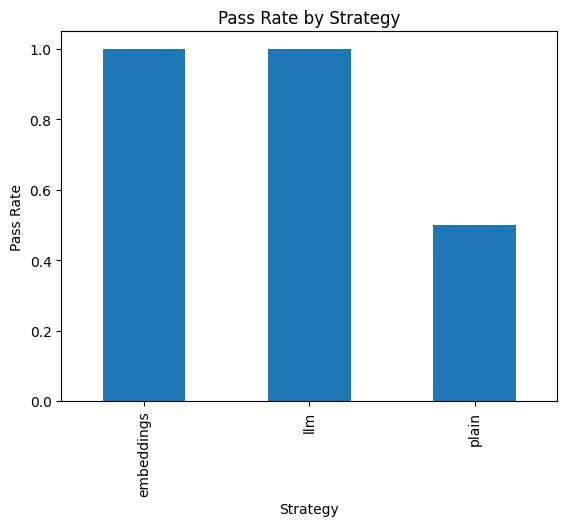

In [31]:
# Pass rate per strategy
agg = df.groupby(["strategy","status"]).size().unstack(fill_value=0)
display(agg)

# Convert to pass rates
total = agg.sum(axis=1)
pass_rate = (agg.get("pass", 0) / total).fillna(0)
display(pass_rate.to_frame("pass_rate"))

# Simple bar chart (matplotlib, single plot, no specific colors)
plt.figure()
pass_rate.plot(kind='bar')
plt.title("Pass Rate by Strategy")
plt.xlabel("Strategy")
plt.ylabel("Pass Rate")
plt.show()

### HTML report with clickable screenshot links

In [32]:
from IPython.display import HTML, display
from pathlib import Path
import time

REPORT_DIR = Path("/content/reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

def _files_href(abs_path: str) -> str:
    # Turn '/content/.../file.png' into 'files/content/.../file.png' for Colab links
    if not abs_path:
        return ""
    p = abs_path
    if p.startswith("/"):
        p = p[1:]
    return f"files/{p}"

def html_report(df):
    df2 = df.copy()

    # Convert screenshot paths to links
    if "screenshot" in df2.columns:
        df2["screenshot"] = df2["screenshot"].apply(
            lambda p: f'<a href="{_files_href(p)}" target="_blank">screenshot</a>' if isinstance(p, str) and p.endswith(".png") else ""
        )

    # Shorten long notes in display (but keep full text in HTML title tooltip)
    def short_notes(n):
        if not isinstance(n, str): return ""
        s = n if len(n) <= 120 else n[:117] + "..."
        return f'<span title="{n}">{s}</span>'

    if "notes" in df2.columns:
        df2["notes"] = df2["notes"].apply(short_notes)

    html = """
    <h3>Selenium vs AI — Run Report</h3>
    <style>
      table {border-collapse: collapse; font-family: sans-serif; font-size: 13px;}
      td,th {border:1px solid #ccc; padding:6px 8px;}
      th {background:#f5f5f5;}
    </style>
    """ + df2.to_html(escape=False, index=False)

    ts = int(time.time())
    out_path = REPORT_DIR / f"run_report_{ts}.html"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(html)

    # Show inline and print a link to open/download
    display(HTML(html))
    print(f"Saved report: {out_path}")
    print(f"Open in new tab: {_files_href(str(out_path))}")

# Generate the report
html_report(df)


page_version,strategy,status,confidence,selector,latency_ms,notes,screenshot,topk_preview
v1,plain,pass,NaN,#loginBtn,NaN,,screenshot,NaN
v1,embeddings,pass,0.8829,[data-testid='signin-btn'],12.0,,screenshot,"[(0.8829, 0)]"
v1,llm,pass,0.9500,[data-testid='signin-btn'],1268.0,Text matches and has preferred data-testid,screenshot,NaN
v2,plain,fail,NaN,#loginBtn,NaN,"\n#1 0x5cad9977b8a0 \n#2 0x5cad997cd540 \n#3 0x5cad997cd731 \n#4 0x5cad9981b824 \n#5 0x5cad997f305d \n#6 0x5cad99818c23 \n#7 0x5cad997f2e03 \n#8 0x5cad997bf968 \n#9 0x5cad997c05e1 \n#10 0x5cad99cca548 \n#11 0x5cad99cce272 \n#12 0x5cad99cb1313 \n#13 0x5cad99ccedc5 \n#14 0x5cad99c9649f \n#15 0x5cad99cf3158 \n#16 0x5cad99cf3332 \n#17 0x5cad99d05a53 \n#18 0x7afb45232ac3 \n"">Message: no such element: Unable to locate element: {""method"":""css selector"",""selector"":""[id=""loginBtn""]""}\n (Session...",screenshot,NaN
v2,embeddings,pass,0.8955,[data-testid='login-cta'],11.0,,screenshot,"[(0.8955, 0)]"
v2,llm,pass,0.9500,[data-testid='login-cta'],1277.0,Text matches and has preferred data-testid,screenshot,NaN


Saved report: /content/reports/run_report_1758002129.html
Open in new tab: files/content/reports/run_report_1758002129.html


Open the file explorer and checkout the generated reports and screens

## 12) Explainability & Debugging Artifacts

- For embeddings, print top-K candidates with similarity scores and their compact strings.

- (If LLM enabled) Show the model’s returned JSON (index, selector, confidence, reason).

Success = You can justify the chosen element and tune thresholds confidently.

In [28]:
# For embeddings runs, show top-k similarity for v2 (if available)
emb_rows = [r for r in results if r.get("strategy")=="embeddings" and r.get("page_version")=="v2"]
if emb_rows:
    row = emb_rows[0]
    print("Top-K (similarity, candidate_index):", row.get("topk_preview"))
    # Recompute to print short candidate strings for those indices
    url = f"{BASE}/v2.html"
    cands = extract_candidates(requests.get(url).text)
    for sim, idx in row.get("topk_preview", []):
        print(sim, "|", stringify_candidate(cands[idx]))
else:
    print("No embeddings rows to explain (did you disable RUN_EMBEDDINGS?).")

print("\nCheck the JSON output from LLM strategy in the run_llm() return.")

Top-K (similarity, candidate_index): [(0.8955, 0)]
0.8955 | tag=button | text=Log in | attrs=type:button,id:ctaLogin,class:button primary-cta,data-testid:login-cta | context=Log in

Check the JSON output from LLM strategy in the run_llm() return.


127.0.0.1 - - [16/Sep/2025 05:51:23] "GET /v2.html HTTP/1.1" 200 -


# Summary

## What you built

* A **controlled demo** with two HTML versions:

  * **v1**: stable UI → brittle Selenium test **passes**.
  * **v2**: renamed/moved/auth button → brittle Selenium test **fails**.
* Two **AI self-healing** strategies that recover when the locator breaks:

  * **Embeddings** (open-source models): intent↔candidate **cosine similarity**, **threshold = 0.72**.
  * **LLM reranker** (optional): strict **JSON** response with `{index, confidence, selector, reason}` and the same **0.72** threshold.
* An **experiment harness** that runs all strategies on both pages and logs results with:

  * `status`, `confidence`, `selector`, `latency_ms`, `notes`, `topk_preview`, and **`screenshot`**.
* A **downloadable HTML report** with clickable screenshot links.

## Key takeaways

* **Brittleness is real:** Small DOM changes (id/class/testid/text/structure) break exact-match locators (ID/CSS/XPath).
* **Intent-driven recovery:** Encoding *what we meant to click* + DOM candidates lets AI pick the right element even after mutation.
* **Safety first:** Use **fail-closed thresholds** (0.72), **scoped search** (`CANDIDATE_SCOPE = ".auth-panel"`), and clear logs to avoid risky clicks.
* **Explainability matters:** Keep **top-K similarities** (embeddings) and **rationales** (LLM) so decisions are auditable.
* **Artifacts help debugging:** Per-run **screenshots** + the **HTML report** make outcomes easy to review and share.

## What “good” looks like in your run

* **Plain Selenium**

  * v1: **pass**
  * v2: **fail** with `NoSuchElementException` (expected)
* **Embeddings**

  * v1: **pass** (often selects `[data-testid='signin-btn']`)
  * v2: **pass** (often selects `[data-testid='login-cta']`) with similarity ≥ **0.72**
* **LLM** (if enabled)

  * v1/v2: **pass** with `confidence ≥ 0.72`, returns a usable `selector` or falls back to ID/testid

## What you can tune next

* **Thresholds:** Raise for safety, lower for recall (`EMBEDDING_THRESHOLD`, `LLM_THRESHOLD`).
* **Scope:** Toggle `CANDIDATE_SCOPE` between `".auth-panel"` and `""` to show how scoping reduces false positives.
* **Intent:** Update `text_like`, add `attrs_preferred`, or introduce **avoid terms** (e.g., “guest”, “trial”).
* **Candidates:** Filter to `button/submit` inputs to cut noise on real pages.

## Common pitfalls (and fixes)

* **Key management:** Don’t hardcode secrets—prompt for the API key (`getpass`) and rotate any exposed keys.
* **API version drift:** Use one current version everywhere.
* **Rate limits:** Add simple **retry/backoff** around model calls (429/5xx).
* **Snap Chromium in Colab:** Prefer **google-chrome-stable** + **webdriver-manager** (already set up).

## Extensions (ideas for v2 of the lab)

* **Ambiguity tests:** Add look-alike buttons and demonstrate scoping/threshold effects.
* **Reports:** Auto-save a richer HTML/PDF report with screenshots and top-K explanations.
* **Heavier mutations:** Change button copy to “Proceed” and show how updating `text_like` helps.
* **Production tie-ins:** Log to your CI, store DOM snapshots, or integrate with a visual tool (Applitools, Playwright trace).

## Cleanup & reset

* To re-run cleanly, just **re-execute** the runner cell; the local server is a daemon thread and doesn’t need manual teardown.
* Set `CANDIDATE_SCOPE` back to `".auth-panel"` after demos with an empty scope.

